FPN  
prev model: model_20

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, RandomHorizontalFlip, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm
from hack_train import predict

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from fpn import LandmarksResNext101FPN

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [4]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 90 * len(GPUs)
LR = 5e-4
NUM_WORKERS = 24
MODEL_NAME = 'model_22'

In [5]:
CHECKPOINT_MODEL_NAME = None

In [6]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in stqdm(loader, total=len(loader), desc="training...", leave=True):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [8]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in stqdm(loader, total=len(loader), desc="validation...", leave=True):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [9]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
#     RandomHorizontalFlip(0.5),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
    TransformByKeys(transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)), ("image",)),
])

In [10]:
test_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
])

In [11]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), test_transforms, split="val")

Total lines (without header): 393930
Loading train dataset (315144 lines)



Total lines (without header): 393930
Loading val dataset (78786 lines)


In [12]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                   shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                 shuffle=False, drop_last=False)

In [13]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [14]:
model = LandmarksResNext101FPN()
model = nn.DataParallel(model, device_ids=GPUs)
model.to(device)

DataParallel(
  (module): LandmarksResNext101FPN(
    (fpn): CustomBackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): Ba

In [15]:
# with open(os.path.join(DATA_DIR, f"{CHECKPOINT_MODEL_NAME}_best.pth"), "rb") as fp:
#     best_state_dict = torch.load(fp, map_location="cpu")
#     model.load_state_dict(best_state_dict, strict=False)

In [16]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
train_loss_fn = fnn.smooth_l1_loss
val_loss_fn = fnn.mse_loss

In [17]:
N_EPOCHS = 100
best_val_loss = np.inf
for epoch in stqdm(range(N_EPOCHS), total=N_EPOCHS, desc="Epoch"):
    train_loss = train(model, train_dataloader, train_loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, val_loss_fn, device=device)
    lr_scheduler.step(val_loss)
    print("Epoch #{:2}:\ttrain loss (smooth_l1): {:.5f}\tval loss (mse): {:.5f}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

Epoch # 0:	train loss (smooth_l1): 3.76642	val loss (mse): 16.09548


Epoch # 1:	train loss (smooth_l1): 1.43802	val loss (mse): 6.20953


Epoch # 2:	train loss (smooth_l1): 1.13200	val loss (mse): 4.08066


Epoch # 3:	train loss (smooth_l1): 0.83860	val loss (mse): 2.54381


Epoch # 4:	train loss (smooth_l1): 0.75097	val loss (mse): 2.19219


Epoch # 5:	train loss (smooth_l1): 0.71087	val loss (mse): 2.21348


Epoch # 6:	train loss (smooth_l1): 0.64815	val loss (mse): 1.96361


Epoch # 7:	train loss (smooth_l1): 0.62013	val loss (mse): 1.92136


Epoch # 8:	train loss (smooth_l1): 0.59671	val loss (mse): 2.00635


Epoch # 9:	train loss (smooth_l1): 0.57115	val loss (mse): 1.89257


Epoch #10:	train loss (smooth_l1): 0.54965	val loss (mse): 1.85853


Epoch #11:	train loss (smooth_l1): 0.53357	val loss (mse): 1.69107


Epoch #12:	train loss (smooth_l1): 0.51903	val loss (mse): 1.80149


Epoch #13:	train loss (smooth_l1): 0.50351	val loss (mse): 1.69326


Epoch #14:	train loss (smooth_l1): 0.43971	val loss (mse): 1.63279


Epoch #15:	train loss (smooth_l1): 0.42397	val loss (mse): 1.64296


Epoch #16:	train loss (smooth_l1): 0.41253	val loss (mse): 1.56635


Epoch #17:	train loss (smooth_l1): 0.40365	val loss (mse): 1.56852


Epoch #18:	train loss (smooth_l1): 0.39481	val loss (mse): 1.58698


KeyboardInterrupt: 

In [18]:
f'Best validation loss: {best_val_loss}'

'Best validation loss: 1.5663515529403949'

In [19]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.000125
    weight_decay: 0.01
)

In [20]:
lr_scheduler.state_dict()

{'factor': 0.5,
 'min_lrs': [0],
 'patience': 1,
 'verbose': False,
 'cooldown': 0,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.0001,
 'threshold_mode': 'rel',
 'best': 1.5663515529403949,
 'num_bad_epochs': 0,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 19,
 '_last_lr': [0.000125]}

In [21]:
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [22]:
test_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'test'), test_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                  shuffle=False, drop_last=False)

Total lines (without header): 99819


In [23]:
test_predictions = predict(model, test_dataloader, device)
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)

In [24]:
create_submission(DATA_DIR, test_predictions,
                 os.path.join(DATA_DIR, f"{MODEL_NAME}_submit_val_loss_{best_val_loss:.5f}.csv"))

In [25]:
TEST_PREDICTIONS_FILENAME = os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl")
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [26]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [27]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


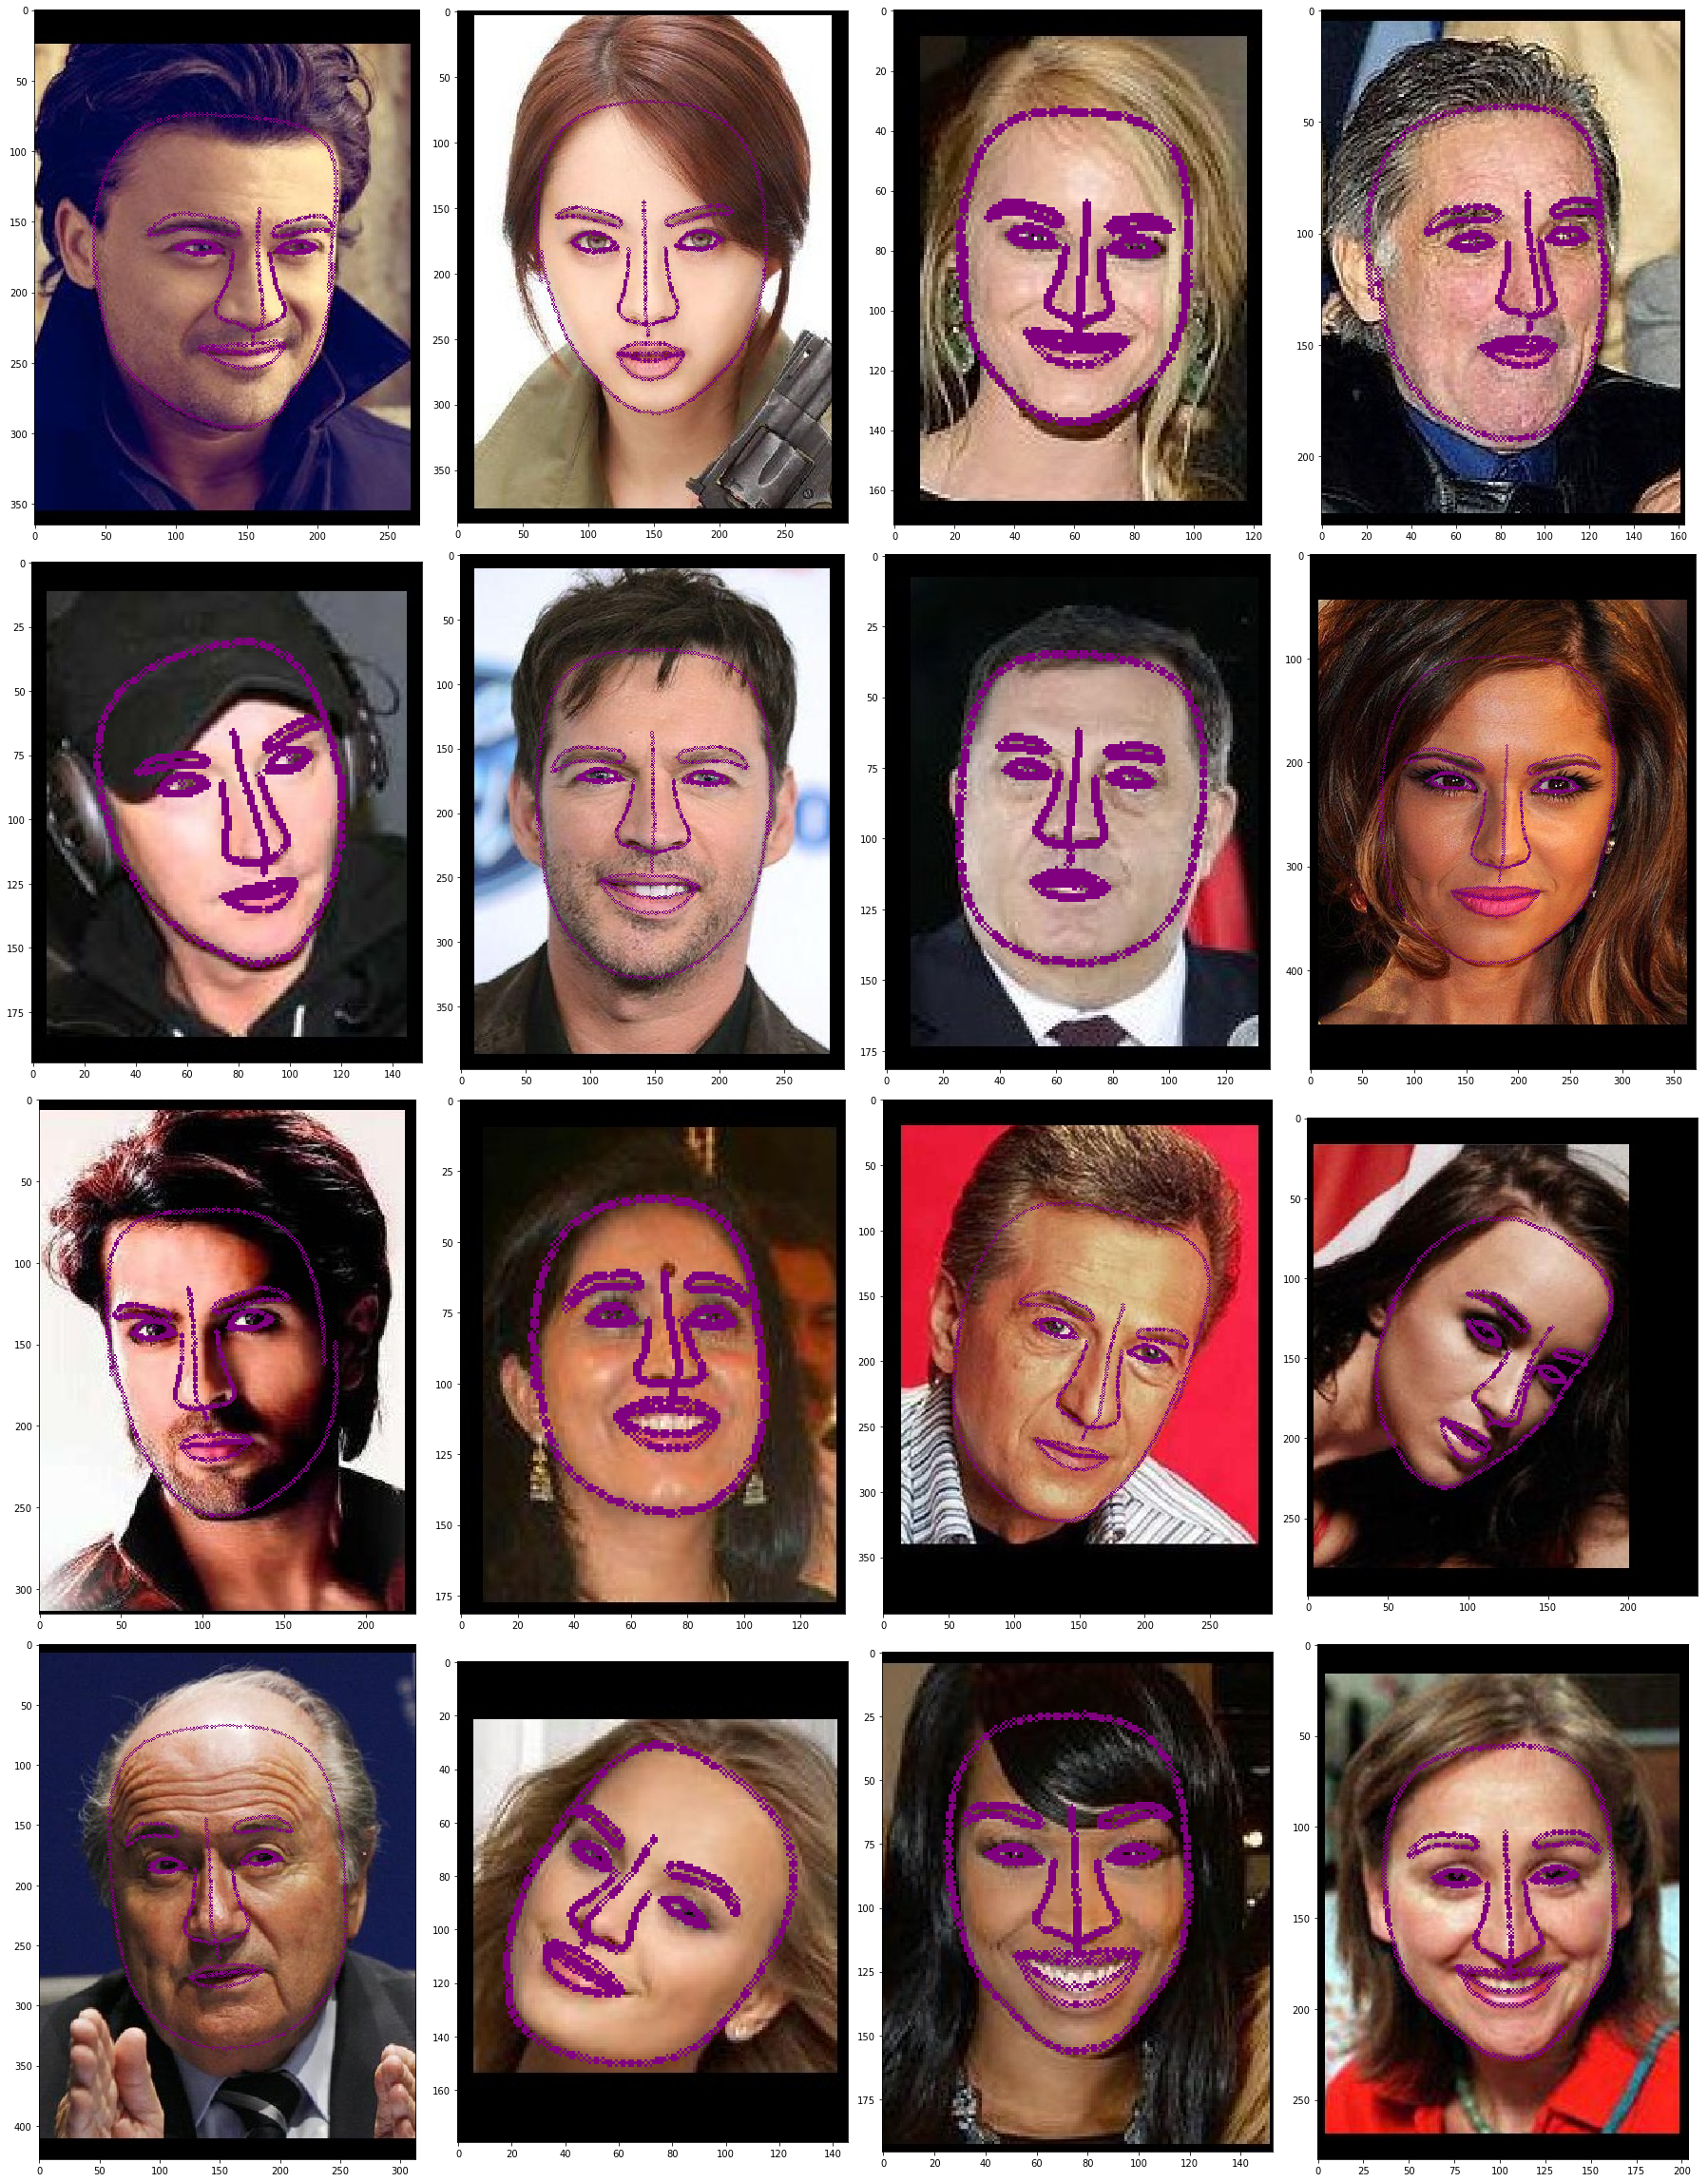

In [28]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()